In [83]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.discrete.discrete_model import Logit
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint, proportions_ztest, proportions_chisquare
from pandas_datareader import DataReader
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import itertools

In [2]:
def dot_plot(data) :
    """Make a R-type dotplot for integer results"""
    if data.dtype != 'int' :
        raise ValueError('Data is not all integers.')
    else :
        x = np.arange(np.min(data), np.max(data) + 1)
        y = np.bincount(data)[np.min(data):]
        
        plot_x = []
        plot_y = []
        
        for a, b in zip(x, y) :
            count = b
            while b >= 1 :
                plot_x.append(a)
                plot_y.append(b)
                b -= 1
                if b == 1 :
                    plot_x.append(a)
                    plot_y.append(1)
                    break
        
        plt.figure(figsize = (12, 5))
        plt.plot(plot_x, plot_y, linestyle = 'None', marker = 'o', markerfacecolor = 'white', markeredgecolor = 'firebrick')
        plt.xticks([int(x_x) for x_x in np.arange(np.min(x), np.max(x) + 1)])
        if np.max(y) > 25 :
            plt.yticks([int(y_y) for y_y in np.arange(1, np.max(y) + 5) if y_y % 5 == 0])
        else :
            plt.yticks([int(y_y) for y_y in np.arange(1, np.max(y) + 1)])
        plt.show()

In [3]:
def ecdf_plot(data) :
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.figure(figsize = (8, 5))
    plt.plot(x, y)
    plt.show()

In [4]:
def outliers_by_IQR(data) :
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    data_no_outliers = data[(data > (q1 - (1.5 * (q3-q1)))) & (data < (q3 + (1.5 * (q3-q1))))]
    print ('Lower:', q1 - (1.5 * (q3-q1)))
    print ('Upper:', q3 + (1.5 * (q3-q1)))
    return data_no_outliers

In [5]:
df = pd.read_csv("http://www.datadescant.com/stat104/survey.csv")

In [6]:
stats.describe(df['height'])

DescribeResult(nobs=127, minmax=(50, 80), mean=67.67716535433071, variance=25.696537932758403, skewness=-0.7639407845995339, kurtosis=1.3235195058817055)

In [7]:
df['height'].quantile([0, 0.25, 0.5, 0.75, 1])

0.00    50.0
0.25    64.0
0.50    68.0
0.75    71.0
1.00    80.0
Name: height, dtype: float64

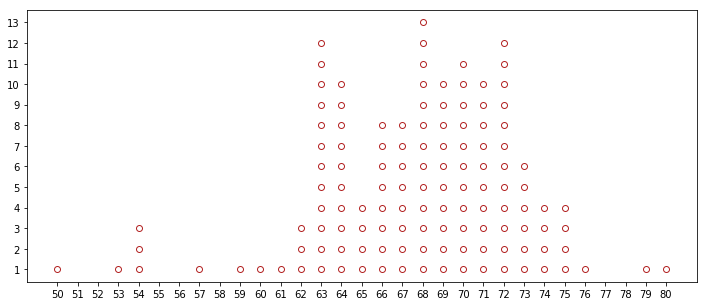

In [8]:
dot_plot(df['height'])

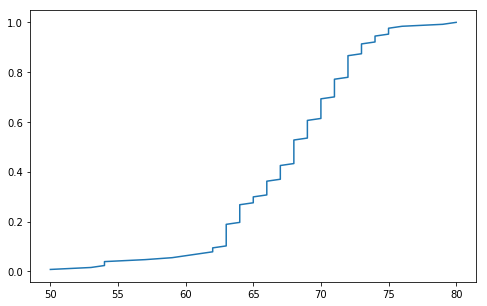

In [9]:
ecdf_plot(df['height'])

In [10]:
height_no_outliers = outliers_by_IQR(df['height'])

Lower: 53.5
Upper: 81.5


In [11]:
#Discrete
print ('dbinom (density) =', stats.binom.pmf(7, 10, .5))
print ('pbinom (probability) =', stats.binom.cdf(5, 20, .1))

dbinom (density) = 0.11718750000000014
pbinom (probability) = 0.988746865835491


In [12]:
#Continuous
print ('pnorm =', stats.norm.cdf(38000,35000,4000))
print ('qnorm =', stats.norm.ppf(0.02, 5100, 200))

pnorm = 0.7733726476231317
qnorm = 4689.250217873636


In [13]:
#Student's t test -- tsum.test
def get_conf_interval_from_sample(n, mean, sigma, alpha = 0.95) :
    """Get confidence interval from sample data with sample of n, mean, sigma, where df = n-1
    Equivalent to getting confidence interval using t.test / tsum.test in R"""
    df = n-1
    scale = sigma / np.sqrt(n)
    return stats.t.interval(alpha=alpha, df=df, loc=mean, scale=scale)

get_conf_interval_from_sample(121, 65, 22)

(61.04013918989445, 68.95986081010555)

In [14]:
#equivalent to binom.confint in R
print ('asymptotic / Wald CI:', proportion_confint(40, 100))
#count = # of p, nobs = # of trials
#defaults: alpha = 0.05, method = 'normal' (asymptotic / Wald)
#Agresti-Coull CI: method = 'agresti_coull'
print ('Agresti-Coull CI:', proportion_confint(40, 100, method = 'agresti_coull'))

asymptotic / Wald CI: (0.3039817664728938, 0.4960182335271062)
Agresti-Coull CI: (0.3093314332131455, 0.4980672664282516)


In [15]:
accord = pd.read_csv('http://people.fas.harvard.edu/~mparzen/stat104/accordprices.csv')

In [18]:
accord = accord.iloc[:,:3]

In [20]:
accord = accord.dropna()

In [21]:
#NOTE: if using sm.OLS (no formula) v smf.ols (with formula), you must add the constant
results = sm.OLS(accord['Price'].values, sm.add_constant(accord['Odometer'].values)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     182.1
Date:                Thu, 25 Apr 2019   Prob (F-statistic):           4.44e-24
Time:                        21:13:46   Log-Likelihood:                -712.30
No. Observations:                 100   AIC:                             1429.
Df Residuals:                      98   BIC:                             1434.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.707e+04    169.025    100.972      0.000    1.67e+04    1.74e+04
x1            -0.0623      0.005    -13.495      0.000      -0.071      -0.053
==============================================================================
Omnibus:                        1.495   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.208
Skew:                           0.025   Prob(JB):                        0.547
Kurtosis:                       2.464   Cond. No.                     2.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
results_f = smf.ols('Price ~ Odometer', data = accord).fit()

In [23]:
results_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     182.1
Date:                Thu, 25 Apr 2019   Prob (F-statistic):           4.44e-24
Time:                        21:13:51   Log-Likelihood:                -712.30
No. Observations:                 100   AIC:                             1429.
Df Residuals:                      98   BIC:                             1434.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.707e+04    169.025    100.972      0.000    1.67e+04    1.74e+04
Odometer      -0.0623      0.005    -13.495      0.000      -0.071      -0.053
==============================================================================
Omnibus:                        1.495   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.208
Skew:                           0.025   Prob(JB):                        0.547
Kurtosis:                       2.464   Cond. No.                     2.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
#b0 and b1
results_f.params

Intercept    17066.766070
Odometer        -0.062315
dtype: float64

In [167]:
#Residual standard error
np.sqrt(results_f.scale)

303.1375029266019

In [191]:
#Standard errors for each variable
results_f.bse

Intercept    169.024644
Odometer       0.004618
dtype: float64

In [217]:
ci_x = tuple(results_f.conf_int().iloc[1])
tuple(round(x, 3) for x in ci_x)

(-0.071, -0.053)

In [284]:
def ols_fit_results_onevar(data, dep, ind, params = 'key', rounded = True, print_results = True) :
    lm = smf.ols('{} ~ {}'.format(dep, ind), data = data).fit()
    if params == 'key' :
        b0 = lm.params[0]
        b1 = lm.params[1]
        rsq = lm.rsquared
        rse = np.sqrt(lm.scale)
        ci_y = tuple(lm.conf_int().iloc[0])
        ci_x = tuple(lm.conf_int().iloc[1])
        if print_results == True :
            if rounded == True :
                b0, b1, rsq, rse, ci_y, ci_x = round(b0, 3), round(b1, 3), round(rsq, 3), round(rse, 3), tuple(round(y, 3) for y in ci_y), tuple(round(x, 3) for x in ci_x)
                print ('b0: {}\nb1: {}\nRSQ: {}\nRSE: {}\nci_y: {}\nci_x: {}'.format(b0, b1, rsq, rse, ci_y, ci_x))
            else :
                print ('b0: {}\nb1: {}\nRSQ: {}\nRSE: {}\nci_y: {}\nci_x: {}'.format(b0, b1, rsq, rse, ci_y, ci_x))
        else :
            if rounded == True :
                b0, b1, rsq, rse, ci_y, ci_x = round(b0, 3), round(b1, 3), round(rsq, 3), round(rse, 3), tuple(round(y, 3) for y in ci_y), tuple(round(x, 3) for x in ci_x)
                return b0, b1, rsq, rse, ci_y, ci_x
            else :
                return b0, b1, rsq, rse, ci_y, ci_x
    else :
        results = lm.summary()
        if print_results == True :
            print (results)
        else :
            return results

In [282]:
# b0, b1, rse, ci_y, ci_x = ols_fit_results(accord, 'Price', 'Odometer', print_results = False)
ols_fit_results_onevar(accord, 'Price', 'Odometer')

b0: 17066.766
b1: -0.062
RSQ: 0.65
RSE: 303.138
ci_y: (16731.342, 17402.19)
ci_x: (-0.071, -0.053)


In [243]:
#Hypothesis test on regression (b1)
hypothesis = 'Odometer = -0.07'
results_f.t_test(hypothesis)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0623      0.005      1.664      0.099      -0.071      -0.053

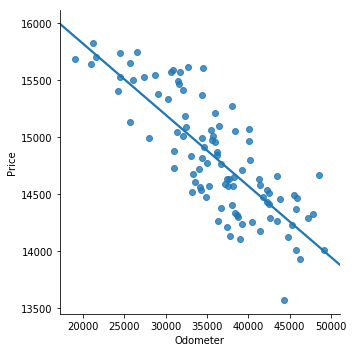

In [242]:
sns.lmplot(x = 'Odometer', y = 'Price', data = accord, ci = None)

In [261]:
#Chi-square goodness of fit
stats.chisquare([32, 28, 16, 14, 10], [20, 20, 20, 20, 20])

Power_divergenceResult(statistic=18.0, pvalue=0.0012340980408667957)

In [277]:
#Chi-square test of independence (contingency table)
table = np.array([[31, 13, 16],
                 [8, 16, 7],
                 [12, 10, 17],
                 [10, 5, 7]])
x2, p, df, e_table = stats.chi2_contingency(table)
print ('chi^2: {}\np-value: {}\nddof: {}\nexpected values:\n{}'.format(x2, p, df, e_table))

chi^2: 14.701859098145798
p-value: 0.022706740169378573
ddof: 6
expected values:
[[24.07894737 17.36842105 18.55263158]
 [12.44078947  8.97368421  9.58552632]
 [15.65131579 11.28947368 12.05921053]
 [ 8.82894737  6.36842105  6.80263158]]


In [92]:
#LOWESS SCATTER
def lowess_plot(data, x_name, y_name) :
    endog_y = data[y_name].values
    exog_x = data[x_name].values
    lowess_sorted = lowess(endog_y, exog_x)
    x = [x[0] for x in lowess_sorted]
    y = [y[1] for y in lowess_sorted]
    fig, ax = plt.subplots()
    ax.plot(x, y, c = 'firebrick')
    ax.scatter(exog_x, endog_y, alpha = 0.5)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

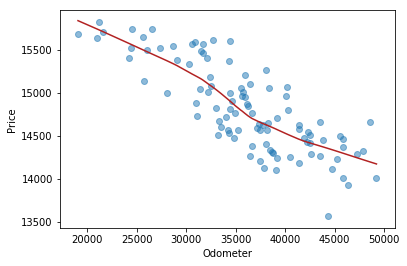

In [93]:
lowess_plot(accord, 'Odometer', 'Price')

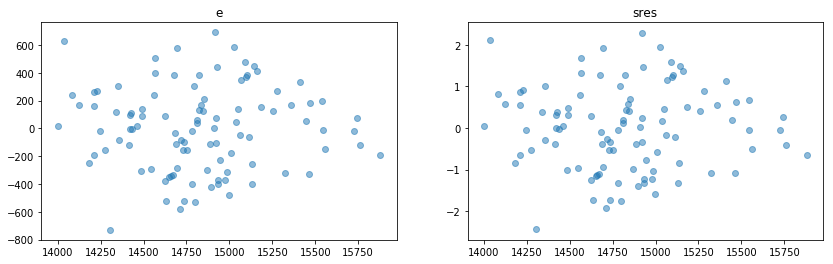

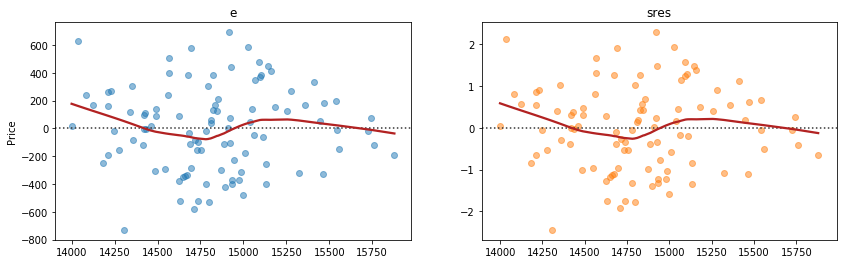

In [99]:
accord = accord.iloc[:, :3]
accord = accord.dropna()
#Obtain residuals manually
results_f = smf.ols('Price ~ Odometer', data = accord).fit()
e = results_f.resid
yhat = results_f.fittedvalues
sres = results_f.get_influence().resid_studentized_internal
#Matplotlib manual
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 4))
ax1.scatter(yhat, e, alpha = 0.5)
ax1.set_title('e')
ax2.scatter(yhat, sres, alpha = 0.5)
ax2.set_title('sres')
plt.show()
#Seaborn
fig, (ax3, ax4) = plt.subplots(ncols = 2, figsize = (14, 4))
sns.residplot(yhat, 'Price', data = accord, lowess = True, ax = ax3, scatter_kws={'alpha': 0.5}, line_kws={'color': 'firebrick'})
ax3.set_title('e')
sns.residplot(yhat, sres, lowess = True, ax = ax4, scatter_kws={'alpha': 0.5}, line_kws={'color': 'firebrick'})
ax4.set_title('sres')
plt.show()

In [100]:
#Alt for getting standardized residual values (standard_resid) & Cook's Distance (cooks_d)
OLSInfluence(results_f).summary_frame().head()

,dfb_Intercept,dfb_Odometer,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.000913,-0.007033,0.000591,-0.334653,0.010441,-0.034375,-0.333132,-0.034219
1,0.059547,-0.070120,0.003871,-0.520742,0.027761,-0.087994,-0.518797,-0.087665
2,0.085547,-0.099020,0.007134,-0.652814,0.032394,-0.119446,-0.650892,-0.119094
3,0.143203,-0.118105,0.018090,1.484682,0.016149,0.190211,1.493986,0.191403
4,0.132631,-0.105489,0.018216,1.584737,0.014300,0.190874,1.597229,0.192378


In [122]:
#normality test - ad.test equivalent in R
stats.anderson(e)

AndersonResult(statistic=0.22242477477628597, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [46]:
#aligns with R bptest where studentize = True, not with ncvTest where studentize = False
#bptest aligns with first p-val [lagrange multiplier p-value]
n_bp_results = ['Lagrange multiplier statistic', 'p-value (USE)','f-value', 'f p-value']
bp_test = het_breuschpagan(results_f.resid, results_f.model.exog)
for a, b in zip(n_bp_results, bp_test) :
    print (a + ' -', b)

Lagrange multiplier statistic - 0.6501084628052878
p-value (USE) - 0.4200739039421577
f-value - 0.6412752784039626
f p-value - 0.42518655226815216


In [27]:
multi_regress_data = pd.read_csv("http://www.datadescant.com/stat104/homer.csv")

In [32]:
m_lm = smf.ols('y ~ x1 + x2 + x3 + x4 + x5 + x6', data = multi_regress_data).fit()

In [44]:
#NOTE: use lm.model.exog because includes intercept (underlying uses sm.OLS, not smf.ols) & therefore i+1 as 0 = b0
for i, x in enumerate(['x1' , 'x2' , 'x3' , 'x4' , 'x5' , 'x6']) :
    print ('x{}: {}'.format(i+1,variance_inflation_factor(m_lm.model.exog, i+1)))

x1: 1.7323765348323794
x2: 2.6110757972151575
x3: 2.662938611631941
x4: 2.409069100198578
x5: 2.5290245122725286
x6: 1.8511074810977328


In [39]:
multi_regress_data.corr()

,y,x1,x2,x3,x4,x5,x6
y,1.000000,0.153736,0.020611,0.091575,0.071136,0.014765,0.397071
x1,0.153736,1.000000,0.531987,-0.381736,0.271562,0.155619,-0.050922
x2,0.020611,0.531987,1.000000,-0.689806,0.459447,0.316200,-0.266501
x3,0.091575,-0.381736,-0.689806,1.000000,-0.643747,-0.443262,0.387561
x4,0.071136,0.271562,0.459447,-0.643747,1.000000,0.643857,-0.384961
x5,0.014765,0.155619,0.316200,-0.443262,0.643857,1.000000,-0.644329
x6,0.397071,-0.050922,-0.266501,0.387561,-0.384961,-0.644329,1.000000


In [74]:
#Data must be positive // gives array and best log
array, maxlog = stats.boxcox(multi_regress_data.iloc[:,1][multi_regress_data.iloc[:,1]>0].values)
print (maxlog)

0.34563374549341913


In [62]:
#Yeo-Johnson allows for negative value transformations
from sklearn.preprocessing import power_transform
power_transform(multi_regress_data.iloc[:,1:], method='yeo-johnson', standardize=True, copy=True)

array([[-0.60891704, -0.16690938,  0.78537324, -1.16848719,  0.2483076 ,
        -1.03576379],
       [ 0.47428091,  0.7271718 , -1.23572436,  0.05497696, -0.70118731,
        -0.29068902],
       [ 1.40095679,  1.64456488, -1.14759691,  1.29242692,  1.06187622,
         0.81565833],
       ...,
       [ 0.53607452,  0.37863853,  0.91563319, -0.80739626, -1.82984436,
         1.8701769 ],
       [-0.00896646, -0.14673669, -1.39125022,  1.6055787 ,  0.86333791,
        -0.12741053],
       [-0.74506898, -1.0154916 ,  0.34366632, -1.20974354, -2.67880915,
         2.63132672]])

In [17]:
#Logistic -- ADD INTERCEPT IF USING SM VERSION, NOT SMF!!!
df_logistic = pd.read_csv('http://www.datadescant.com/stat109/loans.csv')
#On FICO only:
y = df_logistic['default'].values
x = df_logistic['fico'].values
x = sm.add_constant(x)
logistic_m_sm = Logit(y, x).fit()
logistic_m_sm.summary()

Optimization terminated successfully.
         Current function value: 0.427860
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9576
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 May 2019   Pseudo R-squ.:                 0.02706
Time:                        11:49:52   Log-Likelihood:                -4098.0
converged:                       True   LL-Null:                       -4212.0
                                        LLR p-value:                 1.659e-51
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7189      0.577     11.647      0.000       5.588       7.850
x1            -0.0119      0.001    -14.430      0.000      -0.013      -0.010
==============================================================================
"""

In [18]:
logistic_m_smf = smf.logit('default ~ fico', data = df_logistic).fit()
logistic_m_smf.summary()

Optimization terminated successfully.
         Current function value: 0.427860
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9576
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 May 2019   Pseudo R-squ.:                 0.02706
Time:                        11:49:53   Log-Likelihood:                -4098.0
converged:                       True   LL-Null:                       -4212.0
                                        LLR p-value:                 1.659e-51
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7189      0.577     11.647      0.000       5.588       7.850
fico          -0.0119      0.001    -14.430      0.000      -0.013      -0.010
==============================================================================
"""

In [139]:
#One-way ANOVA example
auds = ['Pro-Pal Orgs', 'PIPD Lookalike', 'PIPD Engagement', 'Social Justice Lookalike']
linkclicks = np.random.randint(40, 100, 20)
data = pd.DataFrame(data = {'Audience': auds * 5, 'Link_clicks': linkclicks})

In [140]:
data.loc[data['Audience'] == 'PIPD Lookalike', 'Link_clicks'] = data.loc[data['Audience'] == 'PIPD Lookalike', 'Link_clicks'] + 30
data.loc[data['Audience'] == 'Pro-Pal Orgs', 'Link_clicks'] = data.loc[data['Audience'] == 'Pro-Pal Orgs', 'Link_clicks'] - 30

In [141]:
print (data.groupby('Audience')['Link_clicks'].mean())

Audience
PIPD Engagement             56.2
PIPD Lookalike              91.8
Pro-Pal Orgs                48.0
Social Justice Lookalike    64.0
Name: Link_clicks, dtype: float64


In [142]:
formula = smf.ols('Link_clicks ~ C(Audience)', data = data).fit()
formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Link_clicks   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     9.275
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           0.000866
Time:                        19:30:15   Log-Likelihood:                -78.882
No. Observations:                  20   AIC:                             165.8
Df Residuals:                      16   BIC:                             169.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  56.2000      6.247      8.997      0.000      42.958      69.442
C(Audience)[T.PIPD Lookalike]              35.6000      8.834      4.030      0.001      16.873      54.327
C(Audience)[T.Pro-Pal Orgs]                -8.2000      8.834     -0.928      0.367     -26.927      10.527
C(Audience)[T.Social Justice Lookalike]     7.8000      8.834      0.883      0.390     -10.927      26.527
==============================================================================
Omnibus:                        2.568   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.277   Jarque-Bera (JB):                1.223
Skew:                          -0.182   Prob(JB):                        0.542
Kurtosis:                       1.844   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
sm.stats.anova_lm(formula)

,df,sum_sq,mean_sq,F,PR(>F)
C(Audience),3.0,5428.4,1809.466667,9.27456,0.000866
Residual,16.0,3121.6,195.100000,NaN,NaN


In [144]:
#TUKEY HSD (poss too conservative)
mc = MultiComparison(data['Link_clicks'], data['Audience'])
mc_results = mc.tukeyhsd()
print(mc_results)

            Multiple Comparison of Means - Tukey HSD,FWER=0.05            
     group1              group2          meandiff  lower    upper   reject
--------------------------------------------------------------------------
PIPD Engagement      PIPD Lookalike        35.6   10.3237  60.8763   True 
PIPD Engagement       Pro-Pal Orgs         -8.2   -33.4763 17.0763  False 
PIPD Engagement Social Justice Lookalike   7.8    -17.4763 33.0763  False 
 PIPD Lookalike       Pro-Pal Orgs        -43.8   -69.0763 -18.5237  True 
 PIPD Lookalike Social Justice Lookalike  -27.8   -53.0763 -2.5237   True 
  Pro-Pal Orgs  Social Justice Lookalike   16.0   -9.2763  41.2763  False 
--------------------------------------------------------------------------


In [146]:
#PAIRED T-TESTS
for combo in itertools.combinations(data['Audience'].unique(), 2) :
    a = data[data['Audience'] == combo[0]]['Link_clicks']
    b = data[data['Audience'] == combo[1]]['Link_clicks']
    pval = round(stats.ttest_ind(a, b)[1], 3)
    print (combo, '\np-val: ', pval,  ' || reject: ', pval < 0.05)

('Pro-Pal Orgs', 'PIPD Lookalike') 
p-val:  0.001  || reject:  True
('Pro-Pal Orgs', 'PIPD Engagement') 
p-val:  0.419  || reject:  False
('Pro-Pal Orgs', 'Social Justice Lookalike') 
p-val:  0.09  || reject:  False
('PIPD Lookalike', 'PIPD Engagement') 
p-val:  0.005  || reject:  True
('PIPD Lookalike', 'Social Justice Lookalike') 
p-val:  0.008  || reject:  True
('PIPD Engagement', 'Social Justice Lookalike') 
p-val:  0.379  || reject:  False
